**Setup and Load Dataset**

In [ ]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("CS131 Heart Disease Data Analysis").getOrCreate()

In [ ]:
import pandas as pd

pdf = pd.read_csv('https://raw.githubusercontent.com/csbfx/cs22a/main/heart.csv')

df = spark.createDataFrame(pdf)

df.show(5)


+---+---+----------+----------+-----------+-------------------+--------+--------+----+-------+-----+-----------------+-----------+-------------+
|age|sex|chest_pain|resting_bp|cholesterol|fasting_blood_sugar|rest_ecg|thalachh|exng|oldpeak|slope|num_major_vessels|thalassemia|heart_disease|
+---+---+----------+----------+-----------+-------------------+--------+--------+----+-------+-----+-----------------+-----------+-------------+
| 63|  1|         3|       145|        233|                  1|       0|     150|   0|    2.3|    0|                0|          1|            1|
| 37|  1|         2|       130|        250|                  0|       1|     187|   0|    3.5|    0|                0|          2|            1|
| 41|  0|         1|       130|        204|                  0|       0|     172|   0|    1.4|    2|                0|          2|            1|
| 56|  1|         1|       120|        236|                  0|       1|     178|   0|    0.8|    2|                0|          2|

**Collecting Metadata**

In [ ]:
df.describe().show()
df.groupBy("heart_disease").agg(
    {"thalachh": "avg", "oldpeak": "avg", "chest_pain": "avg"}
).show()
print("Number of rows: ", df.count())

+-------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|               age|               sex|        chest_pain|        resting_bp|       cholesterol|fasting_blood_sugar|         rest_ecg|          thalachh|               exng|           oldpeak|             slope| num_major_vessels|       thalassemia|      heart_disease|
+-------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|               303|               303|               303|               303|               303|                303|              303|               303|     

**Extracting Specific Variables**

In [ ]:
df_selected = df.select(df.columns[2], df.columns[7], df.columns[9], df.columns[13])
df_selected.show(5)

##Chest Pain: This tells us the type of chest pain a person feels: 0 = Typical angina – classic chest pain caused by reduced blood flow to the heart, often triggered by physical activity or stress,
#1 = Atypical angina – chest pain that doesn't follow the usual pattern; it may feel different or happen at unusual times
#2 = Non-anginal pain – chest pain not related to heart problems (like muscle or stomach issues).
#3 = Asymptomatic – no chest pain at all, even if heart disease is present

# Max heart rate achieved (thalachh) – Lower values may indicate poor cardiac health
# ST depression (oldpeak) – Greater depression is linked to ischemia.

+----------+--------+-------+-------------+
|chest_pain|thalachh|oldpeak|heart_disease|
+----------+--------+-------+-------------+
|         3|     150|    2.3|            1|
|         2|     187|    3.5|            1|
|         1|     172|    1.4|            1|
|         1|     178|    0.8|            1|
|         0|     163|    0.6|            1|
+----------+--------+-------+-------------+
only showing top 5 rows



**Creating test and trainind DF**

In [ ]:
trainDF = df_selected.sample(withReplacement=False, fraction=0.8, seed=42)
testDF = df_selected.subtract(trainDF)
trainDF.show(5)
print("Train:", trainDF.count(), "Test:", testDF.count(), "Total:", df_selected.count())

+----------+--------+-------+-------------+
|chest_pain|thalachh|oldpeak|heart_disease|
+----------+--------+-------+-------------+
|         3|     150|    2.3|            1|
|         2|     187|    3.5|            1|
|         1|     178|    0.8|            1|
|         0|     163|    0.6|            1|
|         0|     148|    0.4|            1|
+----------+--------+-------+-------------+
only showing top 5 rows

Train: 251 Test: 48 Total: 303


**Creating Pipeline (Vector + Decision Tree)**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

In [ ]:
assembler = VectorAssembler(
    inputCols=["chest_pain", "thalachh", "oldpeak"],
    outputCol="features"
)

dtC = DecisionTreeClassifier(featuresCol='features', labelCol='heart_disease', maxDepth=4)

pipeline = Pipeline(stages=[assembler, dtC])
model = pipeline.fit(trainDF)

**extracting feature importance**

In [ ]:
dt_model = model.stages[-1] # DecisionTree model is last stage
importances = dt_model.featureImportances
feature_names = ["chest_pain", "thalachh", "oldpeak"]

print("\nFeature Importances:")
for i, score in enumerate(importances):
  print(f"{feature_names[i]}: {score:.4f}")



Feature Importances:
chest_pain: 0.5332
thalachh: 0.1640
oldpeak: 0.3028


**Showing Predicted Results**

In [ ]:
predictions = model.transform(testDF)

predictions.select("chest_pain", "thalachh", "oldpeak", "prediction", "heart_disease").show(5)


+----------+--------+-------+----------+-------------+
|chest_pain|thalachh|oldpeak|prediction|heart_disease|
+----------+--------+-------+----------+-------------+
|         2|     160|    1.4|       1.0|            1|
|         0|     155|    3.1|       0.0|            0|
|         1|     164|    0.0|       1.0|            1|
|         0|     151|    0.4|       1.0|            1|
|         0|     158|    0.6|       1.0|            0|
+----------+--------+-------+----------+-------------+
only showing top 5 rows



**Evaluating Results**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="heart_disease",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.49999999999999994


**Visualizing Our Dataset**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 0 = Individual does not have heart disease
# 1 = Individual has heart disease

1. Boxplot comparing Maximum Heart Rate vs Heart Disease

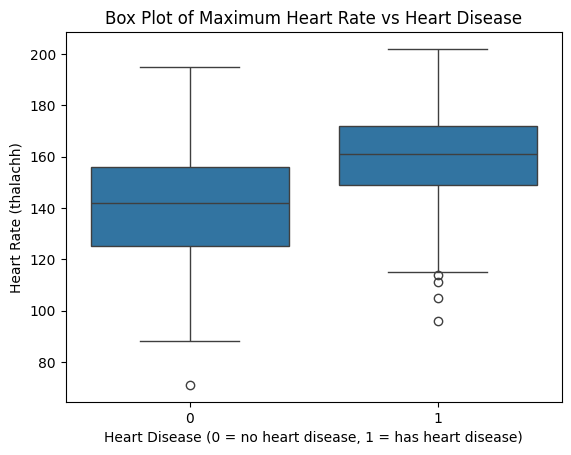

In [ ]:
sns.boxplot(x="heart_disease", y="thalachh", data=pdf)
plt.title("Box Plot of Maximum Heart Rate vs Heart Disease")
plt.xlabel("Heart Disease (0 = no heart disease, 1 = has heart disease)")
plt.ylabel("Heart Rate (thalachh)")
plt.show()

2. Stacked Bar Chart Comparing Different Types of Chest Pains

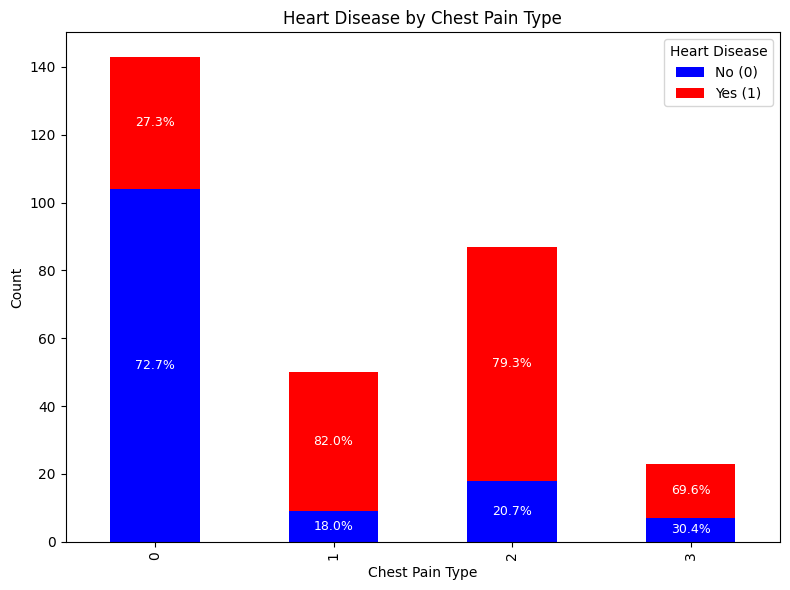

In [ ]:
# Group by chest_pain and heart_disease, count
grouped = df.groupBy("chest_pain", "heart_disease").count()

# Convert to Pandas
grouped_df = grouped.toPandas()

# Pivot to get chest_pain as index and heart_disease (0/1) as columns
pivot = grouped_df.pivot(index="chest_pain", columns="heart_disease", values="count").fillna(0)

# Plot
ax = pivot.plot(kind="bar", stacked=True, figsize=(8,6), color=["blue", "red"])
plt.title("Heart Disease by Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Count")

# Annotate with percentages
for i, row in pivot.iterrows():
    total = row.sum()
    y_offset = 0
    for j, val in enumerate(row):
        percent = val / total * 100
        ax.text(i, y_offset + val / 2, f"{percent:.1f}%", ha='center', va='center', fontsize=9, color="white")
        y_offset += val

plt.legend(title="Heart Disease", labels=["No (0)", "Yes (1)"])
plt.tight_layout()
plt.show()

3. Correlation Matrix of Heart Disease and its Features

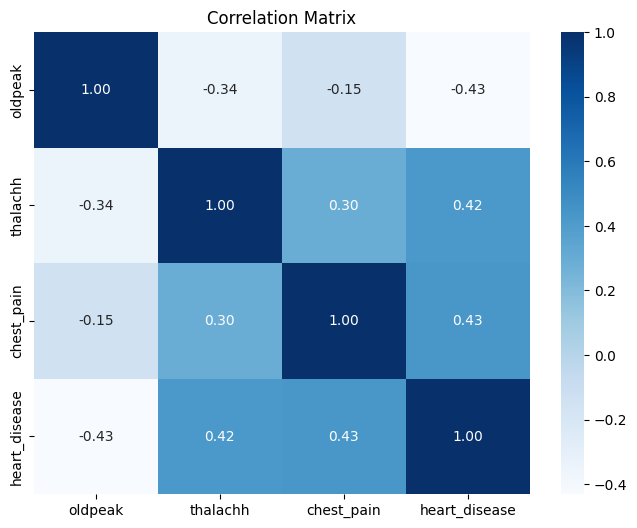

In [ ]:
corr_matrix = pdf[["oldpeak", "thalachh", "chest_pain", "heart_disease"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

4. 3D Scatterplot of Heart Disease and its Features

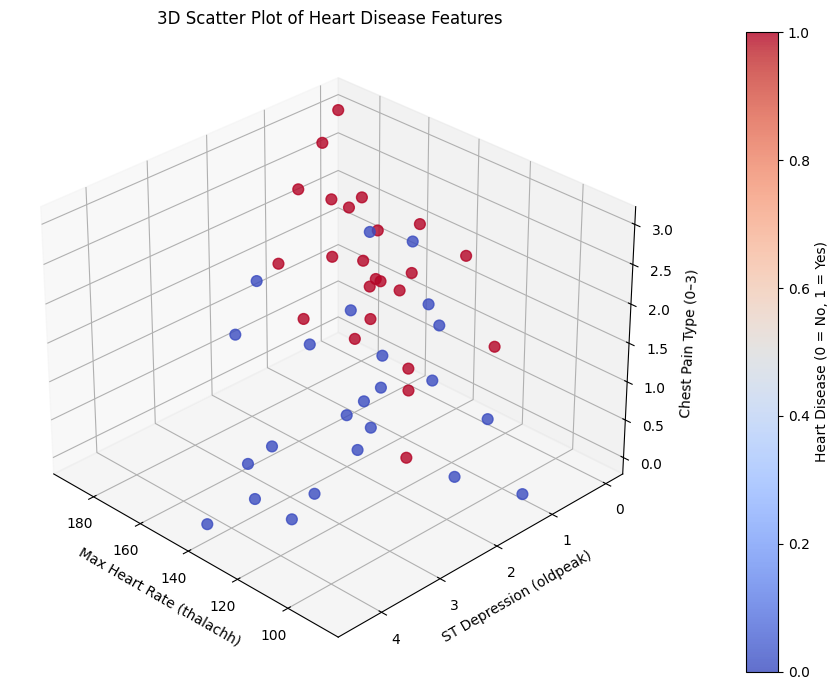

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
plot_df = predictions.select("chest_pain", "thalachh", "oldpeak", "heart_disease").toPandas()
cp_map = {
0: "Typical angina",
1: "Atypical angina",
2: "Non-anginal pain",
3: "Asymptomatic"
}
plot_df["chest_pain_label"] = plot_df["chest_pain"].map(cp_map)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
plot_df["thalachh"],
plot_df["oldpeak"],
plot_df["chest_pain"],
c=plot_df["heart_disease"],
cmap="coolwarm",
s=60,
alpha=0.8
)
ax.set_xlabel("Max Heart Rate (thalachh)")
ax.set_ylabel("ST Depression (oldpeak)")
ax.set_zlabel("Chest Pain Type (0–3)")
ax.set_title("3D Scatter Plot of Heart Disease Features")
ax.view_init(elev=30, azim=135)


cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Heart Disease (0 = No, 1 = Yes)")

plt.tight_layout()
plt.show()

In [ ]:
# Pull describe table
summary_pd = df.select("chest_pain", "thalachh", "oldpeak").describe().toPandas()
summary_pd.set_index('summary', inplace=True)
display(summary_pd)  # Or use summary_pd.style for nicer formatting
group_avg = df.groupBy("heart_disease").agg(
    {"thalachh": "avg", "oldpeak": "avg", "chest_pain": "avg"}
).toPandas()

group_avg.columns = ["heart_disease", "avg_thalachh", "avg_oldpeak", "avg_chest_pain"]
group_avg = group_avg.sort_values("heart_disease")
display(group_avg)
import seaborn as sns
import matplotlib.pyplot as plt



,chest_pain,thalachh,oldpeak
summary,,,
count,303,303,303
mean,0.966996699669967,149.64686468646866,1.0396039603960396
stddev,1.0320524894832985,22.905161114914076,1.1610750220686346
min,0,71,0.0
max,3,202,6.2


,heart_disease,avg_thalachh,avg_oldpeak,avg_chest_pain
1,0,1.585507,139.101449,0.478261
0,1,0.583030,158.466667,1.375758
